Read iris.names file

In [1]:
import pandas as pd
irisName = open("iris.names","r")
print(irisName.read())

1. Title: Iris Plants Database
	Updated Sept 21 by C.Blake - Added discrepency information

2. Sources:
     (a) Creator: R.A. Fisher
     (b) Donor: Michael Marshall (MARSHALL%PLU@io.arc.nasa.gov)
     (c) Date: July, 1988

3. Past Usage:
   - Publications: too many to mention!!!  Here are a few.
   1. Fisher,R.A. "The use of multiple measurements in taxonomic problems"
      Annual Eugenics, 7, Part II, 179-188 (1936); also in "Contributions
      to Mathematical Statistics" (John Wiley, NY, 1950).
   2. Duda,R.O., & Hart,P.E. (1973) Pattern Classification and Scene Analysis.
      (Q327.D83) John Wiley & Sons.  ISBN 0-471-22361-1.  See page 218.
   3. Dasarathy, B.V. (1980) "Nosing Around the Neighborhood: A New System
      Structure and Classification Rule for Recognition in Partially Exposed
      Environments".  IEEE Transactions on Pattern Analysis and Machine
      Intelligence, Vol. PAMI-2, No. 1, 67-71.
      -- Results:
         -- very low misclassification rates (0% for t

So our dataset which is stored in iris.data has 5 attributes. Attribute 1-4 are numeric which represent length and width of sepal and petal; The 5th attribute is categorical attribute which is the class name of that particular observation. Format of each observation or row is -sepal length- -sepal width- -petal length- -petal width- -class name-. The dataset has 150 rows.

In [2]:
irisData = pd.read_csv("iris.data", header = None) #the dataset has no header, so parameter for header assigned as "None". This line is to read the iris.data file in csv format without header
irisData.columns = ['sp_len', 'sp_wid', 'pt_len', 'pt_wid','class'] #add header by an anonymous list of header names
irisData.isnull().sum() #this too check if our data frame contains any empty cell

sp_len    0
sp_wid    0
pt_len    0
pt_wid    0
class     0
dtype: int64

In [3]:
df = irisData.drop(['sp_len','sp_wid','class'], axis = 1) #this to define the dataframe including pt_len, pt_wid which are features used to predict the class. I drop the sepal length and sepal width features because coefficient correlation between them and 'Class' is not significant enought (should be equal or larger than 0.95)


By dropping insignificant feature, our model later will get less noise, variance or overfitting 

Now we prepare the data for our decision tree model

In [4]:
import numpy as np
classLabel = np.array(irisData['class']) #the class label is list contains of all values of the column named 'class


I decide to use k-fold cross validation to train the model; and now the data sample with be split at rate of 80:20 in which 80 is for training set and 20 for testing sets.  

In [5]:
import sklearn
from sklearn.model_selection import train_test_split
np.random.seed(6) #set random seed
train_x, test_x, train_y, test_y = sklearn.model_selection.train_test_split(df, classLabel, test_size = 0.2, train_size = 0.8) # split data pool into train set and test set by sklearn.
print(test_y)

['Iris-setosa' 'Iris-virginica' 'Iris-setosa' 'Iris-setosa'
 'Iris-virginica' 'Iris-versicolor' 'Iris-virginica' 'Iris-setosa'
 'Iris-virginica' 'Iris-versicolor' 'Iris-virginica' 'Iris-versicolor'
 'Iris-virginica' 'Iris-virginica' 'Iris-versicolor' 'Iris-virginica'
 'Iris-virginica' 'Iris-versicolor' 'Iris-versicolor' 'Iris-setosa'
 'Iris-setosa' 'Iris-virginica' 'Iris-setosa' 'Iris-setosa'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor' 'Iris-virginica'
 'Iris-setosa' 'Iris-versicolor']


In [6]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

treeClsObj = DecisionTreeClassifier()
kFold = KFold(n_splits = 5, shuffle = True) #I use k = 5 here
tmpRes = []
for train,valid in kFold.split(train_x, train_y): #As k = 5 means we are gonna iterate our training set five times
    tmpDf_X = pd.DataFrame(train_x)
    tmpDf_Y = pd.DataFrame(train_y)
    kFoldTrain_x, kFoldTrain_y = tmpDf_X.iloc[train] , tmpDf_Y.iloc[train] #delare the iterated training set 
    valid_x, valid_y = tmpDf_X.iloc[valid] , tmpDf_Y.iloc[valid] #declare iterated validation set
    treeClsObj.fit(kFoldTrain_x,kFoldTrain_y)
    pre = treeClsObj.predict(valid_x) 
    acc = metrics.accuracy_score(pre, valid_y) #compare the predicted outcomes from validating features to thier actual values
    tmpRes.append(acc)
    print(acc)
print(np.mean(tmpRes))

0.9166666666666666
0.875
1.0
1.0
0.875
0.9333333333333332


Overall accuracy throughout k-fold cross validation with k = 5 is 93.33%. Now test our tree model with unseen data. 

In [7]:
pre = treeClsObj.predict(test_x)
print(metrics.accuracy_score(pre, test_y))

0.9666666666666667


Accuracy of model now is 96.67% on unseen data which is great

In [8]:
!pip install pydotplus
!pip install matplotlib

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


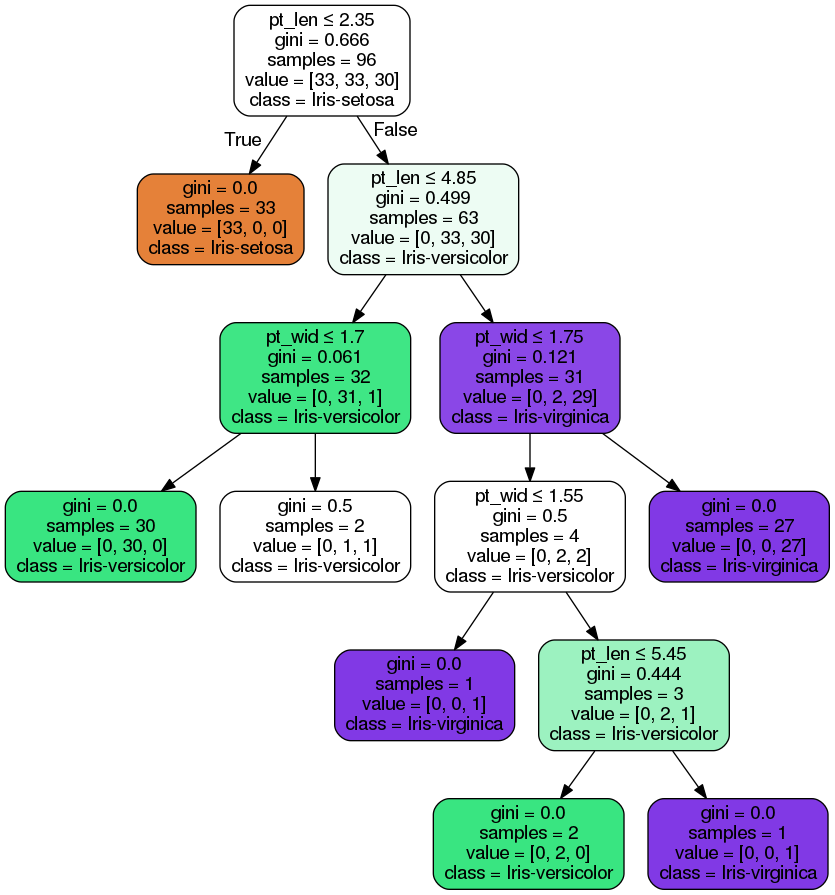

In [9]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(treeClsObj, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = df.columns, class_names = treeClsObj.classes_)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Above is to draw the decision tree

On the plot of tree model above, there are some leaves with insuffucient sample size which means they are noise or our model gets overfitting. To solve this I decide to increase the min sample size of leaves to produce a pruned tree model.

Overall Validating Accuracy:  0.9583333333333334
Testing Accuracy:  0.9333333333333333


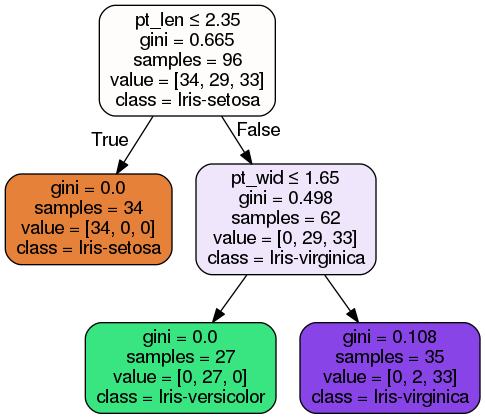

In [11]:
newTreeObj = DecisionTreeClassifier(min_samples_leaf = 20)
kFoldNew = KFold(n_splits = 5, shuffle = True) #I use k = 5 here
tmpRes = []
for train,valid in kFoldNew.split(train_x, train_y): #As k = 5 means we are gonna iterate our training set five times
    tmpDf_X = pd.DataFrame(train_x)
    tmpDf_Y = pd.DataFrame(train_y)
    kFoldTrain_x, kFoldTrain_y = tmpDf_X.iloc[train] , tmpDf_Y.iloc[train] #delare the iterated training set 
    valid_x, valid_y = tmpDf_X.iloc[valid] , tmpDf_Y.iloc[valid] #declare iterated validation set
    newTreeObj.fit(kFoldTrain_x,kFoldTrain_y)
    pre = newTreeObj.predict(valid_x) 
    acc = metrics.accuracy_score(pre, valid_y) #compare the predicted outcomes from validating features to thier actual values
    tmpRes.append(acc)
print('Overall Validating Accuracy: ',np.mean(tmpRes))
print('Testing Accuracy: ',metrics.accuracy_score(newTreeObj.predict(test_x), test_y))

dot_data = StringIO()
export_graphviz(newTreeObj, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = df.columns, class_names = treeClsObj.classes_)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Now I'm bored with the tree. I'm gonna pick another data set to work on